# Otsu's Method
Named after Nobuyuki Otsu, Otsu's method performs image thresholding based on class variance. Mathematically, it finds a threshold $t$ that minimizes the intra-class variance between the foreground and background,
$$
\sigma^2(t) = \omega_0(t)\sigma^2_0(t) + \omega_1(t) \sigma_1^2(t),
$$
where $\omega_0$ and $\omega_1$ are the probabilities that the two classes are separated by the threshold $t$, and $\sigma_0^2$, $\sigma_1^2$ are the variances of class 0 and 1, the background and foreground, respectively.

Probabilities are easily computed by first creating a histogram of the input image.

### Read Image
You may replace `rice.png` with `coins.bmp`, or any other image that you have.

Read in rice.png. Shape: (512, 512)


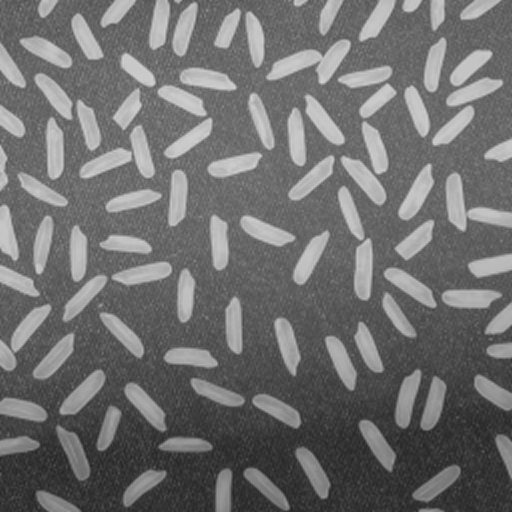

In [148]:
from PIL import Image
import numpy as np

image_path = 'rice.png'

# Read in image and store as an array
image = np.asarray(Image.open(image_path))
if image.ndim > 2:
    # Only use first channel
    image = image[:,:,0]
print(f'Read in {image_path}. Shape: {image.shape}')
Image.fromarray(image)

### Compute Histogram

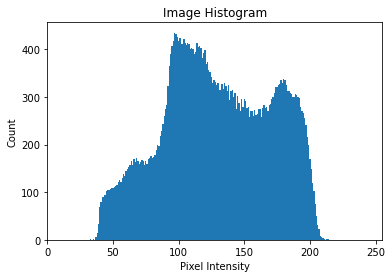

In [149]:
import matplotlib.pyplot as plt

# Use a numpy array to compute histogram by hand
counts = np.zeros(256)
bins = np.arange(0, 256)

for intensity in image:
    counts[intensity] += 1

plt.xlim(bins[0], bins[-1])
plt.bar(bins, counts, width=1)
plt.xlabel('Pixel Intensity')
plt.ylabel('Count')
plt.title('Image Histogram')
plt.show()


### Loop over possible threshold values
Let $t$ be the start of the foreground.

In [150]:
# Intra-class variances
intra_vars = np.zeros(256)

# Total count to compute weight
total_count = np.sum(counts)

# Loop from 0 to 255
for t in np.arange(0,256):
    idx_back    = np.arange(0, t)
    bins_back   = bins[idx_back]
    counts_back = counts[idx_back]
    sum_back    = np.sum(counts_back)
    weight_back = sum_back / total_count
    if sum_back != 0.0:
        mean_back = np.dot(counts_back, bins_back) / sum_back
        var_back = np.dot(np.square(bins_back - mean_back), counts_back)
        var_back /= sum_back
    else:
        mean_back = 0.0
        var_back = 0.0
    
    
    idx_fore = np.arange(t, 256)
    bins_fore = bins[idx_fore]
    counts_fore = counts[idx_fore]
    sum_fore = np.sum(counts_fore)
    weight_fore = sum_fore / total_count
    if sum_fore != 0.0:
        mean_fore = np.dot(counts_fore, bins_fore) / sum_fore
        var_fore = np.dot(np.square(bins_fore - mean_fore), counts_fore)
        var_fore /= sum_fore
    else:
        mean_fore = 0.0
        var_fore = 0.0

    intra_vars[t] = weight_back * var_back + weight_fore * var_fore

intra_threshold = np.argmin(intra_vars)

#### Plot intra-class variance against histogram

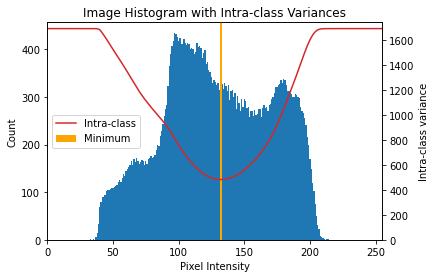

In [151]:
pltymax = np.max(intra_vars) + 50

fig, ax1 = plt.subplots()
ax1.bar(bins, counts, width=1)
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('Count')
ax2 = ax1.twinx()
ax2.plot(bins, intra_vars, color='tab:red', label='Intra-class')
ax2.set_ylabel('Intra-class variance')
plt.ylim(0, pltymax)
plt.bar(intra_threshold, pltymax, color='orange', width=1.5, label='Minimum')
plt.xlim(bins[0], bins[-1])
plt.legend(loc='center left')
plt.title('Image Histogram with Intra-class Variances')
plt.show()

#### Use found threshold on image

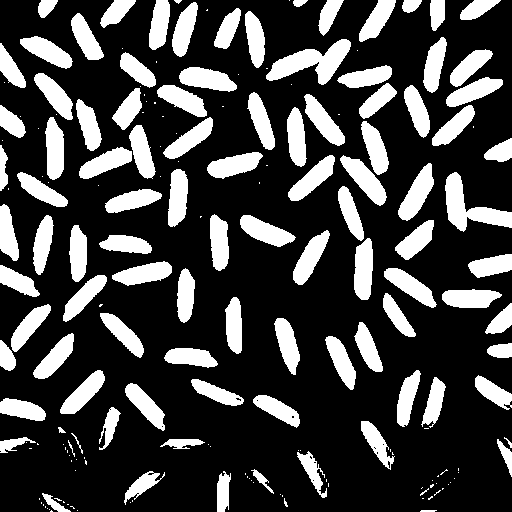

In [152]:
image_thresh = np.copy(image)
image_thresh[image_thresh >= intra_threshold] = 255
image_thresh[image_thresh <  intra_threshold] = 0

Image.fromarray(image_thresh)

#### A faster approach
In Otsu's method, minimizing intra-class variance is equivalent to maximizing inter-class variance,
$$
\sigma^2(t) = \omega_0(t) \omega_1(t) [\mu_0(t) - \mu_1(t)]^2.
$$
Notice that the class variances are no longer needed.

In [153]:
# Inter-class variances
inter_vars = np.zeros(256)

# Total count to compute weight
total_count = np.sum(counts)

# Loop from 0 to 255
for t in np.arange(0,256):
    idx_back    = np.arange(0, t)
    bins_back   = bins[idx_back]
    counts_back = counts[idx_back]
    sum_back    = np.sum(counts_back)
    weight_back = sum_back / total_count
    if sum_back != 0.0:
        mean_back = np.dot(counts_back, bins_back) / sum_back
    else:
        mean_back = 0.0
    
    
    idx_fore = np.arange(t, 256)
    bins_fore = bins[idx_fore]
    counts_fore = counts[idx_fore]
    sum_fore = np.sum(counts_fore)
    weight_fore = sum_fore / total_count
    if sum_fore != 0.0:
        mean_fore = np.dot(counts_fore, bins_fore) / sum_fore
    else:
        mean_fore = 0.0

    inter_vars[t] = weight_back * weight_fore * (mean_back - mean_fore) ** 2

inter_threshold = np.argmax(inter_vars)

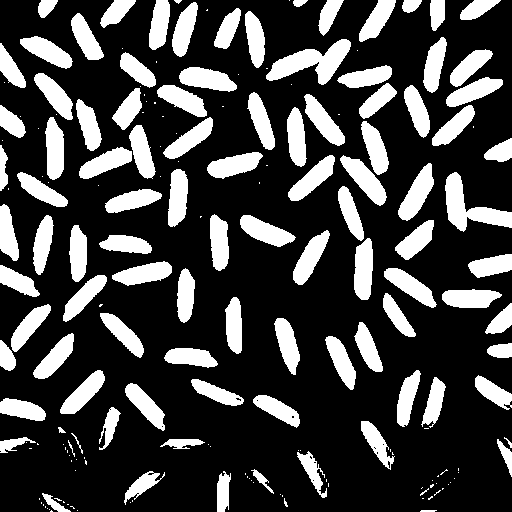

In [154]:
image_thresh = np.copy(image)
image_thresh[image_thresh >= inter_threshold] = 255
image_thresh[image_thresh <  inter_threshold] = 0

Image.fromarray(image_thresh)

#### Plot inter-class variance

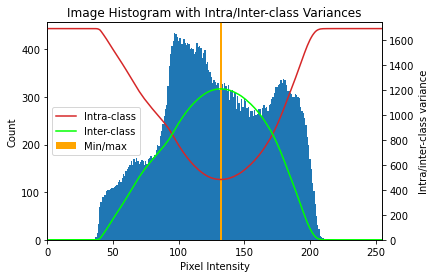

In [155]:
pltymax = np.max(intra_vars) + 50

fig, ax1 = plt.subplots()
ax1.bar(bins, counts, width=1)
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('Count')
ax2 = ax1.twinx()
ax2.plot(bins, intra_vars, color='tab:red', label='Intra-class')
ax2.plot(bins, inter_vars, color='lime', label='Inter-class')
ax2.set_ylabel('Intra/inter-class variance')
plt.ylim(0, pltymax)
plt.bar(intra_threshold, pltymax, color='orange', width=1.5, label='Min/max')
plt.xlim(bins[0], bins[-1])
plt.legend(loc='center left')
plt.title('Image Histogram with Intra/Inter-class Variances')
plt.show()